# 1. What is Machine Learning?
Machine learning is a scientific discipline that explores the construction and study of algorithms that can *learn* from data. Such algorithms operate by building a model from example inputs an using that to make *predictions* or *decisions*, rather than following strictly static instructions. 

We can take an example of predicting the type of flower based on sepal length and width of the flower. Let's say we have some data (discretized iris data set on sepal length and width). The data set looks like:

In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


# Seaborn Plot Styling
sns.set(style="white", palette="husl")
sns.set_context("poster")
sns.set_style("ticks")
%matplotlib inline

In [123]:
iris = load_iris()
mini_iris = np.round(iris.data[:, :2]).astype(int)
data = pd.DataFrame(mini_iris, columns=['length', 'width'])
data['type'] = iris.target

#Shuffle data
data = data.iloc[np.random.permutation(len(data))]

In [124]:
data.head()

,length,width,type
37,5,3,0
98,5,2,1
55,6,3,1
69,6,2,1
23,5,3,0


## 2. Different ways of learning from data
Now, let's say we want to predict the type of flower for a new given data point. There are multiple ways to solve this problem. We will consider these two ways in some detail:
1. We could find a **function** which can directly map an input value to its class label. 
2. We can find the probability distributions over the variables and then use this distribution to answer queries about the new data point. 

There are a lot of algorithms for finding a mapping function. For example, **linear regression** tries to find a linear equation which explains the data. **Support vector machines** try to find a plane which separates the data points. **Decision Trees** try to find a set of simple greater than and less than equations to classify the data. Let's try to apply a decision on this data set. 

We can plot the data and it looks something like this:

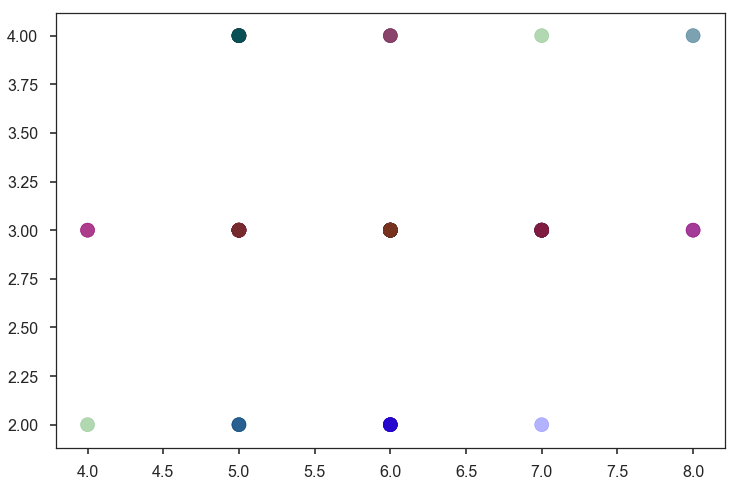

In [125]:
# Plot data without noise
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(data.length, data.width, c=['b', 'g', 'r'], s=200, alpha=0.3)

We can see that many of our points directly overlap. We can add some noise to make it easier to visualize:

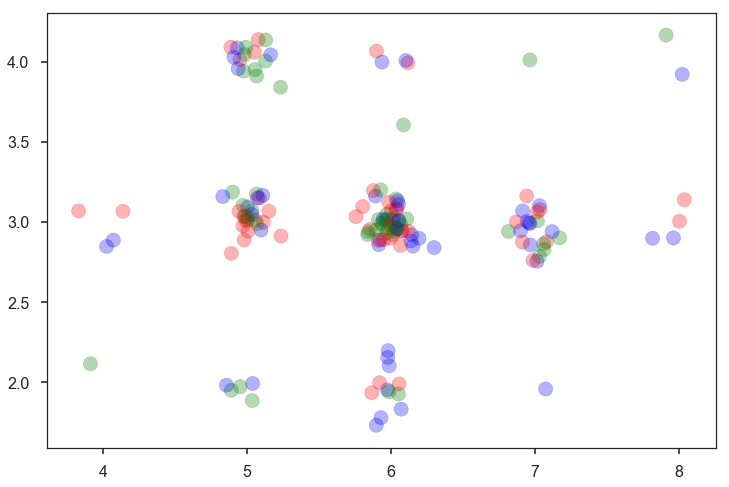

In [126]:
# Adding a little bit of noise so that it's easier to visualize
data_with_noise = data.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(data_with_noise.length, data_with_noise.width, c=['b', 'g', 'r'], s=200, alpha=0.3)

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(data.ix[:, ['length', 'width']]
                                                    .values, data.type.values, test_size=0.2)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [129]:
classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)
classifier.predict(X_test)

array([2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2,
       0, 2, 2, 0, 2, 2, 0, 1])

In [130]:
classifier.score(X_test, y_test)

0.6666666666666666

So, in this case we got a classification accuracy of 70%. 

Now, let's move on to our second approach using a probabilistic model. The most obvious way to do this classification task would be to compute a Joint Probability Distribution over all these variables and then marginalize and reduce over these according to our new data point to get the probabilities of each class.

In [131]:
X_train, X_test = data[:120], data[120:]

In [132]:
X_train.head()

,length,width,type
37,5,3,0
98,5,2,1
55,6,3,1
69,6,2,1
23,5,3,0


In [133]:
X_train.shape

(120, 3)

In [134]:
# Computing the joint probability distribution over the training data
joint_prob = X_train.groupby(['length', 'width', 'type']).size() / 120
joint_prob 

length  width  type
4       2      0       0.008333
        3      0       0.025000
5       2      1       0.033333
        3      0       0.141667
               1       0.008333
        4      0       0.100000
6       2      1       0.058333
               2       0.016667
        3      1       0.191667
               2       0.166667
        4      0       0.033333
7       2      2       0.008333
        3      1       0.066667
               2       0.091667
        4      2       0.008333
8       3      2       0.025000
        4      2       0.016667
dtype: float64

In [135]:
# Predicting values

# Selecting just the feature variables.
X_test_features = X_test.iloc[:, :2].values
X_test_actual_results = X_test.iloc[:, 2].values

predicted_values = []
for i in X_test_features:
  predicted_values.append(np.argmax(joint_prob[i[0], i[1]]))
    
predicted_values = np.array(predicted_values)
predicted_values

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


array([0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0,
       0, 0, 2, 0, 2, 1, 1, 1])

In [136]:
# Lets compare with our actual data
predicted_values == X_test_actual_results

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

In [137]:
score = (predicted_values == X_test_actual_results).sum() / len(X_test_actual_results)
score

0.7666666666666667

# Why Probabilistic Graphical Models
We just saw how Bayesian inference workds. We construct a Joint Distribution over the data and then condition on the observed variable to compute the posterior distribution. We then query on this posterior distribution to predict the values of the new data points. 

However, the problem with this method is that the Joint Probability Distribution is exponential to the number of states (*cardinality*) of each variable. So, for problems having a lot of features or having high cardinality of features, inference becomes a difficult task because of computational limits. For example, for 10 random variables each  having 10 states, the size of the Joint Distribution would be $10^{10}$. 

**Probabilistic Graphical Models (PGM):** PGM is a technique of compactly representing a Joint Probability Distribution over random variables, by exploiting the (conditional) independencies between the variables. PGM also provides us methods for efficiently doing inference over these joint distributions. 

Each graphical model is characterized by a graph structure (can be directed, undirected or both) and a set of parameters associated with each graph.

The problem in the above example can be represented using a Bayesian Model (a type of graphical model).